# Прогнозирование температуры звезды

Поставлена задача от обсерватории, придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики:
- `Относительная светимость L/Lo` — светимость звезды относительно Солнца.
- `Относительный радиус R/Ro` — радиус звезды относительно радиуса Солнца.
- `Абсолютная звёздная величина Mv` — физическая величина, характеризующая блеск звезды.
- `Звёздный цвет` (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- `Тип звезды`.

    Тип звезды и номер, соответствующий типу:
    - Коричневый карлик	- 0
    - Красный карлик - 1
    - Белый карлик	2
    - Звёзды главной последовательности	- 3
    - Сверхгигант - 4
    - Гипергигант - 5
- `Абсолютная температура T(K)` — температура на поверхности звезды в Кельвинах.

In [1]:
#!pip install -q torch

In [2]:
#!pip install -q skorch

## Шаг 1. Загрузка данных

Импортируем библиотеки:

In [3]:
from math import ceil
from math import sqrt
import random
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.regressor import NeuralNetRegressor
from skorch.dataset import ValidSplit
import torch
from torch import nn


SEED=777

Прочитаем датасет и сохраним в переменную:

In [4]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)

Выведем 7 случайных строк датасета:

In [5]:
df.sample(7)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
189,3523,0.000957,0.12900,16.35,0,Red
160,25390,223000.000000,57.00000,-5.92,4,Blue
2,2600,0.000300,0.10200,18.70,0,Red
186,2968,0.000461,0.11900,17.45,0,Red
133,2989,0.008700,0.34000,13.12,1,Red
145,8924,0.000280,0.00879,14.87,2,Blue white
119,3780,200000.000000,1324.00000,-10.70,5,Red


Выведем общую информацию о данных в датасете:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [7]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


В датасете 240 строк и 6 столбцов. Тип данных в столбцах - `float64`, `int64` и `object` - соответствует содержащимся в них типам данных. 

К признакам относятся следующие колонки:

- `Absolute magnitude(Mv)` - абсолютная звёздная величина Mv, характеризующая блеск звезды;
- `Luminosity(L/Lo)` - светимость звезды относительно Солнца;
- `Radius(R/Ro)` - радиус звезды относительно радиуса Солнца;
- `Star color` - звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
- `Star type` - тип звезды.

Целевой признак:

- `Temperature (K)` - температура звезды в Кельвинах.

Столбцы `Luminosity(L/Lo)`, `Radius(R/Ro)`, `Absolute magnitude(Mv)` - количественные; данные значения нужно масштабировать.
Столбцы `Star type` и `Star color` - категориальные; данные в них необходимо категоризовать для обучения модели.

## Шаг 2. Предобработка и анализ данных

### Предобработка данных

Переименуем столбцы в соответствие с snake_case:

In [8]:
df = df.rename(columns = 
              {'Temperature (K)' : 'temperature',
               'Luminosity(L/Lo)' : 'luminosity',
               'Radius(R/Ro)' : 'radius',
               'Absolute magnitude(Mv)' : 'absolute_magnitude',
               'Star type' : 'star_type',
               'Star color' : 'star_color'}
              )

In [9]:
df.sample(3)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
209,19360,0.00125,0.00998,11.62,2,Blue
109,33421,352000.00000,67.00000,-5.79,4,Blue
224,16787,246730.00000,62.00000,-6.35,4,Blue


Столбцы переименованы. Проверим явные дубликаты:

In [10]:
df.duplicated().sum()

0

Явных дубликатов нет. Проверим неявные дубликаты в столбце `star_color` с категориальныим данными:

In [11]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В столбце присутствуют значения с пробелами в конце, значения разного регистра и дефисы, исправим это:

In [12]:
df['star_color'] = df['star_color'].str.strip().str.lower().str.replace('-', ' ')
df['star_color'] = df['star_color'].replace('white yellow', 'yellow white')

df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'yellowish', 'orange red'], dtype=object)

Неявные дубликаты преобразованы.

### Анализ данных

Посмотрим на распределение количественных признаков:

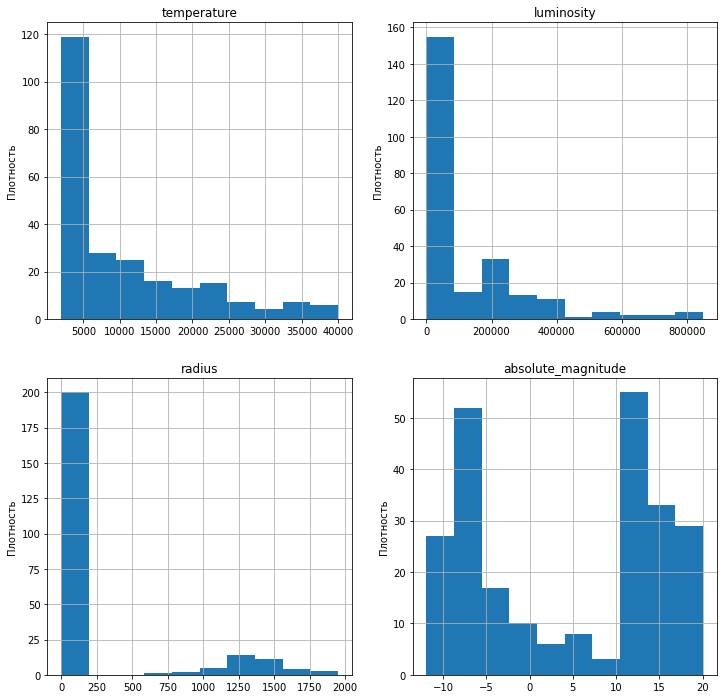

In [16]:
column_list = ['temperature',
               'luminosity',
               'radius',
               'absolute_magnitude']
cnt = 1
plt.figure(figsize=(12, 12))
for column in column_list:
    plt.subplot(2, 2, cnt)
    df[column].hist(bins=10)
    plt.ylabel('Плотность')
    plt.title(column)
    cnt += 1

Согласно полученным графикам, представленные в выборке величины не имеют нормального распределения.Температура, светимость и радиус на графике имеют высокий пик слева и длинный хвость справа. Абсолютная магнитуда имеет два максимума.

Построим матрицу корреляции количественных признаков:

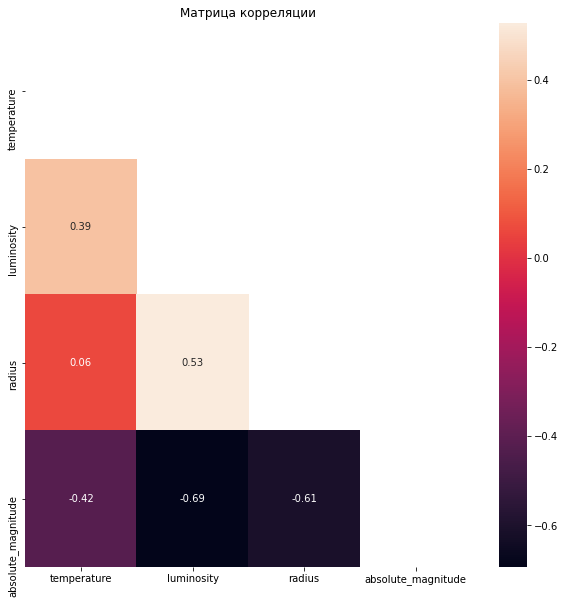

In [17]:
plt.figure(figsize=(10,10))
plt.title('Матрица корреляции')
matrix = np.triu(df[column_list].corr())
sns.heatmap(df[column_list].corr(), annot=True, fmt='.2f', mask=matrix)
None

Согласно полученной матрицы, у абсолютной звёздной величины существует достаточно высокая обратная зависимость по отношению к другим характеристикам - светимости (-0,69), радиусу (-0,61) и температуре (-0,42). Также достаточно высокая прямая зависимость радиуса и светимости (-0,53).

Посмотрим на точечные диаграммы количественных величин:

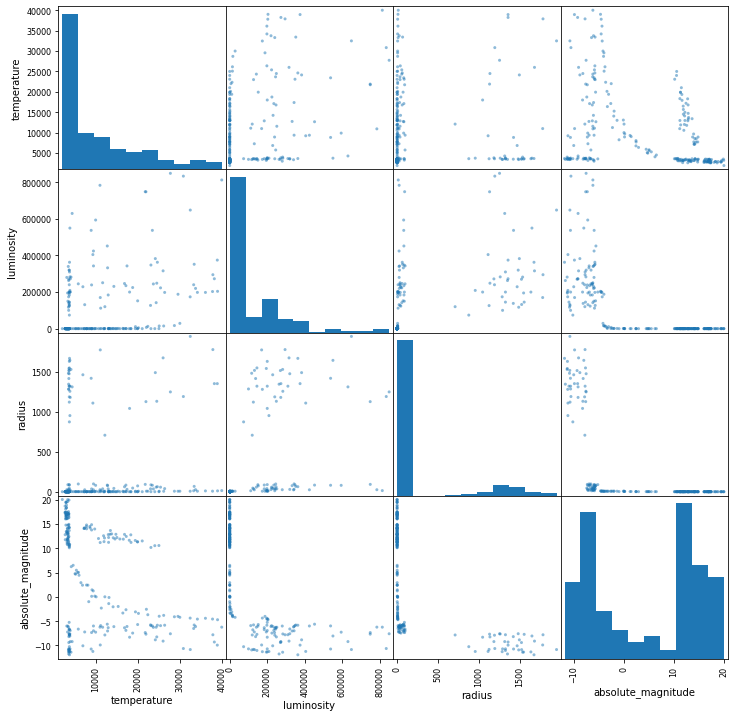

In [18]:
pd.plotting.scatter_matrix(df[[
    'temperature',
    'luminosity',
    'radius',
    'absolute_magnitude']], figsize=(12, 12))
None

Как видно из полученных графиков какой-то определенной взаимосвязи признаков с целевой переменной нет. 

Посмотрим на распределение категориальных признаков:

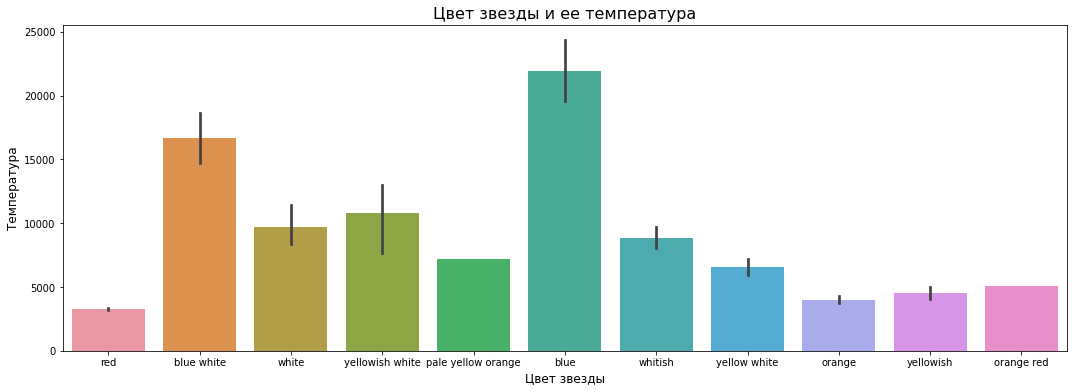

In [19]:
plt.figure(figsize=(18, 6))
sns.barplot(y='temperature', x='star_color', data=df)
plt.title('Цвет звезды и ее температура', fontsize=16)
plt.xlabel('Цвет звезды', fontsize=12)
plt.ylabel('Температура', fontsize=12)
None

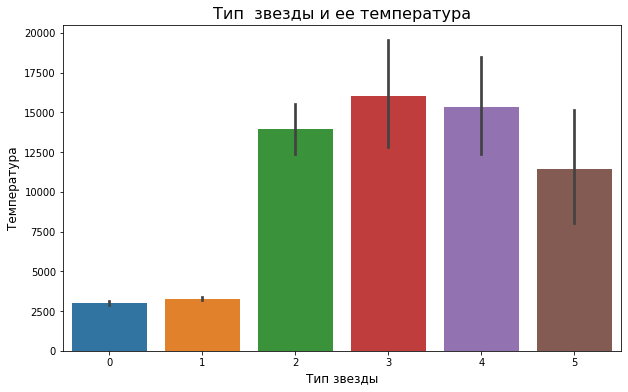

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(y='temperature', x='star_type', data=df)
plt.title('Тип  звезды и ее температура', fontsize=16)
plt.xlabel('Тип звезды', fontsize=12)
plt.ylabel('Температура', fontsize=12)
None

Как видно из графиков, 
- самая высокая температура у звезд 2-5 типа, самая низкая - соответственно у 0 и 1; 
- ниабольшая температура у звезд, имеющих цвет 'blue' и 'blue white', наименьшая - у звезд 'red' и 'orange'.

## Шаг 3. Подготовка данных к построению модели

Разделим датасет на обучающую и тестовую выборку:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('temperature', axis=1),
                                                    df['temperature'],
                                                    test_size=0.25,
                                                    random_state=SEED)

print('Размеры получившихся выборок:\n '
      'X_train:',X_train.shape, '\n',
      'X_test:', X_test.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'y_test:', y_test.shape)

Размеры получившихся выборок:
 X_train: (180, 5) 
 X_test: (60, 5) 
 y_train: (180,) 
 y_test: (60,)


Преобразуем категориальные признаки в численные с помощью техники One-Hot Encoding:

In [22]:
categorical = ['star_color', 'star_type']
ohe = OneHotEncoder()
ohe.fit(X_train[categorical])

train_ohe = ohe.transform(X_train[categorical]).toarray()

test_ohe = ohe.transform(X_test[categorical]).toarray()

cats = ohe.get_feature_names()

X_train = pd.concat([pd.DataFrame(train_ohe, columns=cats),
                     X_train.drop(['star_color', 'star_type'], axis=1).reset_index(drop=True)],axis=1)

X_test = pd.concat([pd.DataFrame(test_ohe, columns=cats),
                    X_test.drop(['star_color', 'star_type'], axis=1).reset_index(drop=True)],axis=1)

А числовые данные отмасштабируем с помощью структуры StandardScaler:

In [23]:
numeric = ['luminosity', 'radius', 'absolute_magnitude']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
#display(X_train.head(), X_test.head())

Значения тренировочной и тестовой выборки преобразуем в тензоры:

In [24]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test  = torch.FloatTensor(y_test .values)

## Шаг 4. Построение базовой нейронной сети

Построим нейросеть с одним скрытым слоем:

In [25]:
class Net(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=(2/n_in_neurons)**0.5)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

Напишем функцию обучения нейронной сети:

In [26]:
def train_func(
    net,
    num_epochs,
    batch_size,
    loss,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test
):
    
    optimizer = optimizer
    num_batches = ceil(len(X_train)/batch_size)
    best_rmse = 10**6
    best_epoch = None
    best_preds = None
    

    for epoch in range(1, num_epochs+1):
        net.train()
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(X_batch).flatten(start_dim=-2)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
            
        if epoch % (num_epochs / 10) == 0 or epoch == num_epochs :
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test)
                rmse = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
                print(f'Эпоха: {epoch}, RMSE: {rmse}')
        
            if rmse < best_rmse:
                best_rmse = rmse
                best_epoch = epoch
                best_preds = test_preds

    print(f'Лучшее RMSE: {best_rmse}',
          f'Лучшая эпоха: {best_epoch}',
          sep='\n')
    
    return best_preds

Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи:

In [27]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=100):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping', f'delta={self.best_loss - val_loss}')
                self.early_stop = True

In [28]:
%%time

test_rmse = list(range(10000, 5000, -500)) + list(range(1000, 6000, 100))

early_stopping = CustomEarlyStopping(patience=2, min_delta=10) #эти параметры можно подбирать

for i in test_rmse:
    print("RMSE: ", i)
    early_stopping(i)
    if early_stopping.early_stop:
        break

RMSE:  10000
RMSE:  9500
RMSE:  9000
RMSE:  8500
RMSE:  8000
RMSE:  7500
RMSE:  7000
RMSE:  6500
RMSE:  6000
RMSE:  5500
RMSE:  1000
RMSE:  1100
INFO: Early stopping counter 1 of 2
RMSE:  1200
INFO: Early stopping counter 2 of 2
INFO: Early stopping delta=-200
CPU times: user 1.35 ms, sys: 210 µs, total: 1.56 ms
Wall time: 905 µs


Вызовем функцию:

In [29]:
%%time
num_epochs = 20000
n_in_neurons = X_train.shape[1]
n_hidden_neurons = 8
n_out_neurons = 1
batch_size = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

net = Net(
    n_in_neurons, 
    n_hidden_neurons, 
    n_out_neurons
)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

preds = train_func(net,
                 num_epochs,
                 batch_size,
                 loss,
                 optimizer,
                 X_train,
                 y_train,
                 X_test,
                 y_test
                )

Эпоха: 2000, RMSE: 9385.908203125
Эпоха: 4000, RMSE: 6192.1142578125
Эпоха: 6000, RMSE: 5233.583984375
Эпоха: 8000, RMSE: 4733.22265625
Эпоха: 10000, RMSE: 4579.5859375
Эпоха: 12000, RMSE: 4531.94482421875
Эпоха: 14000, RMSE: 4532.56103515625
Эпоха: 16000, RMSE: 4545.3896484375
Эпоха: 18000, RMSE: 4558.46435546875
Эпоха: 20000, RMSE: 4576.9443359375
Лучшее RMSE: 4531.94482421875
Лучшая эпоха: 12000
CPU times: user 26.6 s, sys: 136 ms, total: 26.7 s
Wall time: 26.8 s


Таким образом, для рассмотренной нейросети с одним скрытым слоем наилучший показатель метрики RMSE получился равным 4531.94, данная метрика достигается на эпохе 12000. 

Рассмотрим модель с двумя скрытыми слоями и в одном слое используем функцию активации Exponential Linear Unit - ELU():

In [30]:
class Net2(nn.Module):
    
    def __init__(
        self,
        n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        #n_hidden_neurons_3,
        n_out_neurons,
        activation,
        dropout
    ):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation
        self.dp = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        #self.fc3 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_3)
        #self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=(2/n_in_neurons)**0.5)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=(2/n_hidden_neurons_1)**0.5)
        #nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        #nn.init.normal_(self.fc3.bias, mean=0, std=(2/n_hidden_neurons_2)**0.5)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        #x = self.fc3(x)
        #x = self.act3(x)
        x = self.fc4(x)
        return x

Зададим параметры сети и вызовем функцию

In [31]:
%%time
num_epochs = 2000
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 10
#n_hidden_neurons_3 = 10
n_out_neurons = 1
batch_size = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

net = Net2(
    n_in_neurons, 
    n_hidden_neurons_1, 
    n_hidden_neurons_2,
    #n_hidden_neurons_3,
    n_out_neurons, 
    nn.ELU(), 
    0
)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

preds = train_func(net,
                 num_epochs,
                 batch_size,
                 loss,
                 optimizer,
                 X_train,
                 y_train,
                 X_test,
                 y_test
                )

Эпоха: 200, RMSE: 12633.8486328125
Эпоха: 400, RMSE: 7152.04638671875
Эпоха: 600, RMSE: 5825.4365234375
Эпоха: 800, RMSE: 5157.5556640625
Эпоха: 1000, RMSE: 4728.89990234375
Эпоха: 1200, RMSE: 4554.72314453125
Эпоха: 1400, RMSE: 4405.69775390625
Эпоха: 1600, RMSE: 4335.943359375
Эпоха: 1800, RMSE: 4328.90673828125
Эпоха: 2000, RMSE: 4340.76611328125
Лучшее RMSE: 4328.90673828125
Лучшая эпоха: 1800
CPU times: user 3.53 s, sys: 15.4 ms, total: 3.55 s
Wall time: 3.58 s


Вторая сеть показала результаты лучше и в 6 раз быстрее обучилась: метрика RMSE равна 4328.91 и была достигнута на эпохе 1800. В принципе, получившаяся метрика качества удовлетворяет требованиям к проекту. Возьмем эту модель в качестве базовой.

Построим график «Факт — Прогноз» с фактическими и предсказанными значениями базовой модели:

In [32]:
#d.head()

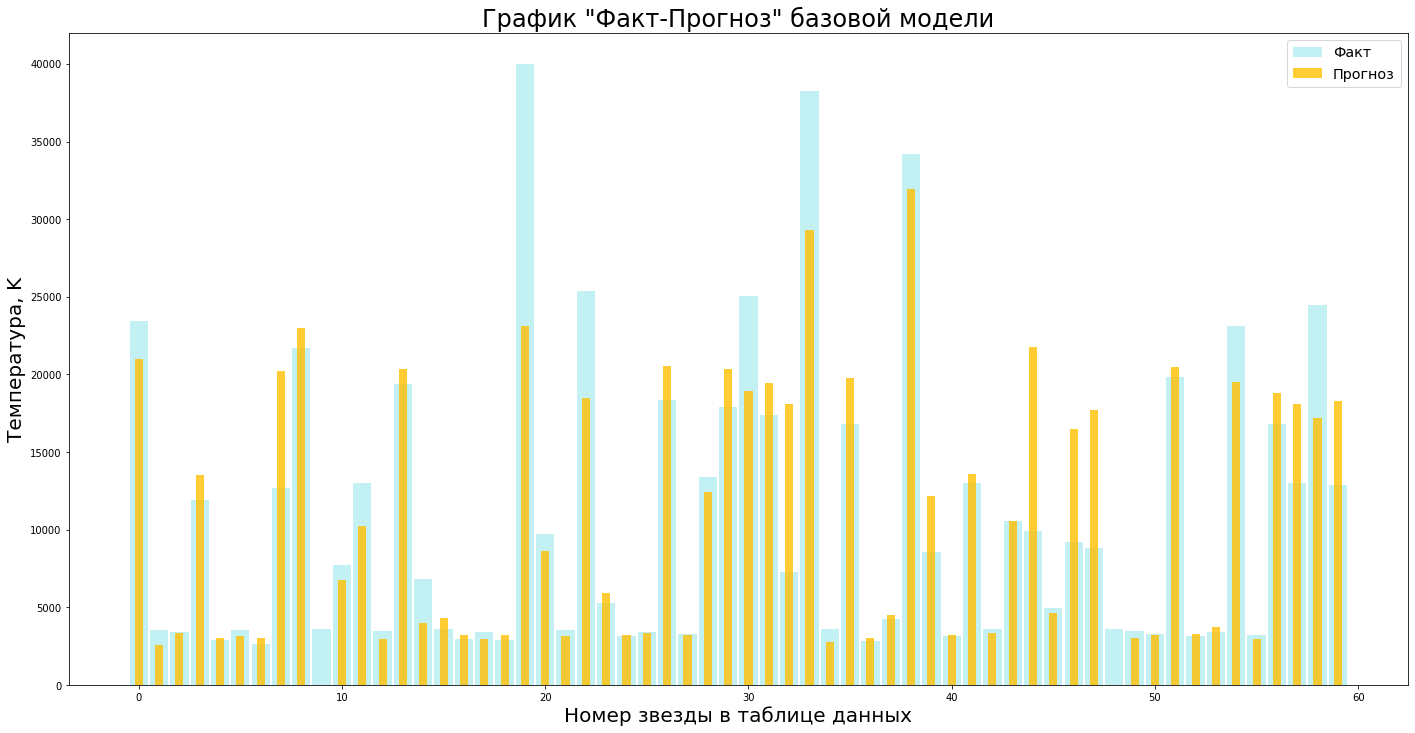

In [33]:
fig, ax = plt.subplots(figsize=(24,12))
ax.bar(
    range(len(y_test)), y_test, label='target', alpha=0.5, width=0.9, color='#89e2e8'
)
ax.bar(
    range(len(y_test)), np.hstack(preds.detach().numpy()),
    label='predicted', alpha=0.8, width=0.4, color='#ffc001'
)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура, K', fontsize=20)
plt.title('График "Факт-Прогноз" базовой модели', fontsize=24)
ax.legend(['Факт', 'Прогноз'], fontsize='x-large')
None

По полученному графику можно сделать вывод, что при фактической температуре звезды менее 10000 Кельвинов базовая модель с наименьшей ошибкой делает предсказание, а, соответственно, при температуре более 10000 Кельвинов - ошибается сильнее.

## Шаг 5. Улучшение нейронной сети

Улучшим базовую модель, подобрав ей параметры dropout, размер batch и learning rate через GridSearchCV и skorch:

In [34]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse)

In [35]:
%%time
#CPU times: user 5min 22s, sys: 9.9 s, total: 5min 32s
#Wall time: 5min 44s

skorch_regressor = NeuralNetRegressor(
    module=net, 
    device='cpu',  
    verbose=0,
    batch_size=100,
    optimizer=torch.optim.Adam, 
    max_epochs=2000,
    lr=0.003,
    train_split=ValidSplit(cv=5),
    criterion=nn.MSELoss,
    callbacks=[
               ('val_rmse',
                EpochScoring(scoring=rmse_scorer,
                             lower_is_better=True,
                             name='RMSE')),
               ('estoper',
                EarlyStopping(lower_is_better=True,
                                         monitor='RMSE',
                                         patience=500))
              ]
)

params = {
          'module__n_in_neurons': [X_train.shape[1]],
          'module__n_hidden_neurons_1': [8],
          'module__n_hidden_neurons_2': [10],
          #'module__n_hidden_neurons_3': [10],
          'module__n_out_neurons': [1],
          'module__dropout': [0, 0.1, 0.5],
          'module__activation': [nn.ELU()],
          'lr': [3e-3, 4e-3],
          'batch_size':[50, 100]
         }

grid = GridSearchCV(skorch_regressor,
                    params,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    verbose=False,
                    n_jobs=-1
                   ) 
grid.fit(X_train, y_train.reshape(-1,1))

CPU times: user 5min 32s, sys: 12 s, total: 5min 44s
Wall time: 5min 47s


GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net2(
    (fc1): Linear(in_features=20, out_features=8, bias=True)
    (act1): ELU(alpha=1.0)
    (dp): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=8, out_features=10, bias=True)
    (act2): ReLU()
    (fc4): Linear(in_features=10, out_features=1, bias=True)
  ),
),
             n_jobs=-1,
             param_grid={'batch_size': [50, 100], 'lr': [0.003, 0.004],
                         'module__activation': [ELU(alpha=1.0)],
                         'module__dropout': [0, 0.1, 0.5],
                         'module__n_hidden_neurons_1': [8],
                         'module__n_hidden_neurons_2': [10],
                         'module__n_in_neurons': [20],
                         'module__n_out_neurons': [1]},
             scoring='neg_root_mean_squared_error', verbose=False)

Найдем оптимизированные параметры улучшенной модели и ее метрику качества RMSE на тестовой выборке:

In [36]:
preds_best_model = grid.predict(X_test)
rmse = mean_squared_error(preds_best_model, y_test, squared=False)
print(f'Оптимизированные параметры улучшенной модели:\n {grid.best_params_}',
      f'RMSE на кросс-валидации: {abs(grid.best_score_)}',
      f'RMSE на тесте: {rmse}',
      sep='\n')

Оптимизированные параметры улучшенной модели:
 {'batch_size': 100, 'lr': 0.004, 'module__activation': ELU(alpha=1.0), 'module__dropout': 0, 'module__n_hidden_neurons_1': 8, 'module__n_hidden_neurons_2': 10, 'module__n_in_neurons': 20, 'module__n_out_neurons': 1}
RMSE на кросс-валидации: 4767.005696614583
RMSE на тесте: 4198.7412109375


RMSE на тестовой выборке получилась равной 4198.74, что выше, чем у базовой модели (4328.91) и также удовлетворяет требованиям проекта.

Аналогично построим график «Факт — Прогноз» с фактическими и предсказанными значениями улучшенной модели:

In [37]:
best_preds = torch.FloatTensor(preds_best_model)

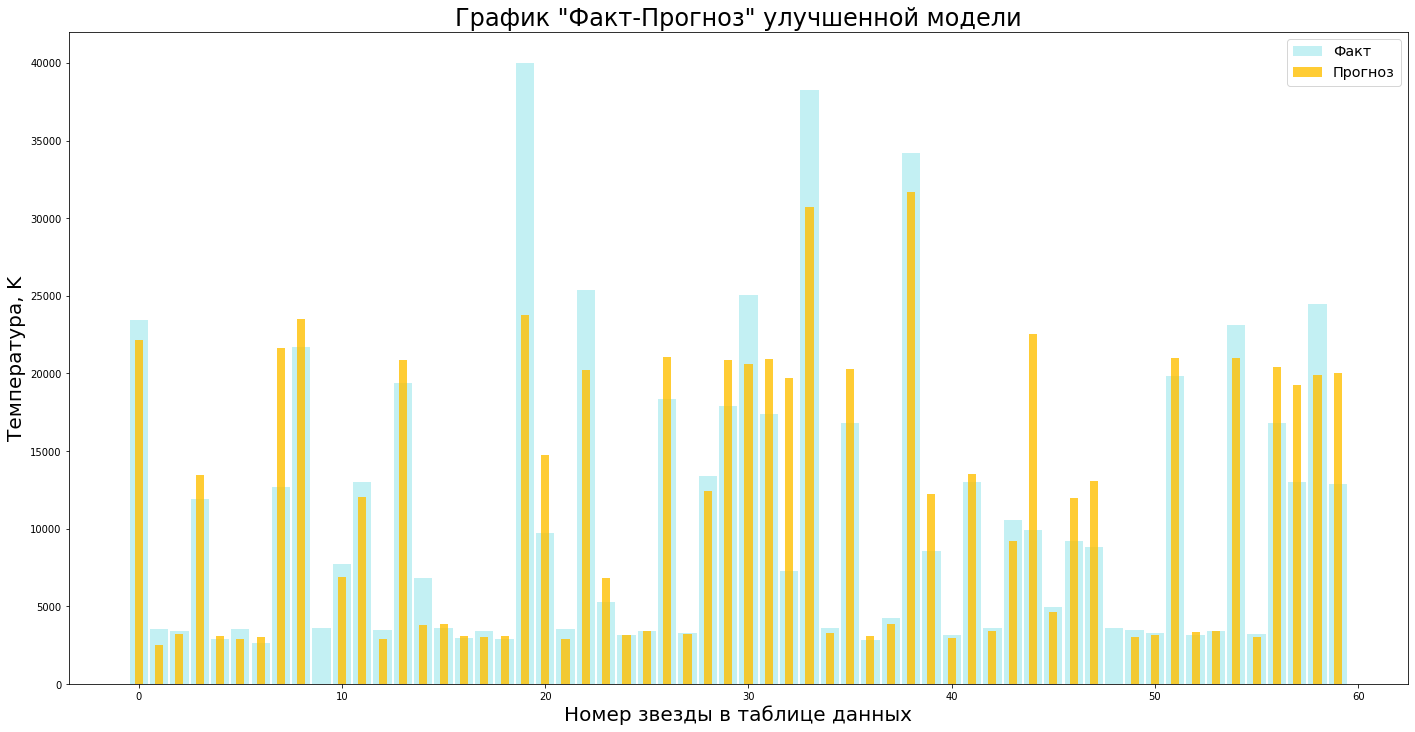

In [38]:
fig, ax = plt.subplots(figsize=(24,12))
ax.bar(
    range(len(y_test)), y_test, label='target', alpha=0.5, width=0.9, color='#89e2e8'
)
ax.bar(
    range(len(y_test)), np.hstack(best_preds.detach().numpy()),
    label='predicted', alpha=0.8, width=0.4, color='#ffc001'
)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура, K', fontsize=20)
plt.title('График "Факт-Прогноз" улучшенной модели', fontsize=24)
ax.legend(['Факт', 'Прогноз'], fontsize='x-large')
None

Визуально полученный график не сильно отличается от полученного ранее - при фактической температуре звезды менее 10000 Кельвинов улучшенная модель ошибается меньше, а, соответственно, при температуре более 10000 Кельвинов - ошибается сильнее. Тем не менее метрика качества улучшенной модели выше.

## Выводы

В рамках данного проекта от обсерватории была поставлена задача разработать нейросеть, способную определять температуру на поверхности обнаруженных звезд. В качестве критерия оценки модели используется метрика качества RMSE.
Для решения поставленной задачи были рассмотрены 2 нейросети - базовая и улучшенная, полученная на основе базовой модели с перебором гиперпараметров.

Архитектура нейросети была выбрана следующая:
 - полносвязная нейронная сеть FNN;
 - на входном слое 20 нейронов - по числу признаков;
 - 2 скрытых слоя с количеством нейронов 8 и 10 соответственно;
 - на выходном слое 1 нейрон, поскольку решается задача регрессии с одним целевым признаком;
 - используемые функции активации ReLU и ELU;
 - функция потерь - среднеквадратичное отклонение MSELoss;
 - инициализация параметров сети по Каймингу, поскольку функция активации ReLU - несимметричная;
 - оптимизатор параметров модели - ADAM.
 
Метрика качества RMSE у базовой модели получилась равной 4328.91. Перебором с помощью GridSearchCV были подобраны наилучшие параметры для улучшенной модели:
- dropout - 0;
- learning_rate - 0.004;
- batch_size - 100.

Благодаря оптимизации этих параметров, улучшенной модели удалось достичь RMSE на тестовой выборке 4198.74, что удовлетворяет требованиям проекта.